# The interplay between PVE and resampling

Performing voxel-wise analysis of repeat acquisitions to assess the performance of PVEc is methodologically challenging due to the confounding effects introduced by registration/resampling that any such analysis requires.

Consider the following situation: 
- A set of repeat ASL acquisitions, all of which are slightly out of alignment with each other. We would like to perform voxel-wise analysis on the outputs, so we need; 
- A space used to perform voxel-wise analysis of CBF estimates with PVEc, for example, the T1-ASL-gridded space (though this argument would apply to *any* space and voxel resolution does have a role to play). The only important requirement is that the CBF maps from each acquisition must be aligned with each other in the analysis space, otherwise a voxel-wise analysis is invalid in the first place. We refer to this as the common aligned space. 

![Experimental layout for Maastricht data](maastricht_layout.png)

The above setup is what I have been trying to do with the Maastricht data, as well as Melvin's PCASL reproducibility data previously. The implication of having a common analysis space, into which all repeat acquisitions must be transformed (whether before or after analysis, ie, raw ASL data or output CBF map), is that the PV map for this space is *fixed*, ie, does not depend on the repeat data itself. This is quite intuitive when using T1-ASL-gridded space; the corresponding PV map for all analysis is simply a resized copy of the T1-space PV estimates (eg FAST). 

The metric that I have been using to assess the performance of PVEc is voxel-wise coefficient of variation, defined generally as follows: (std deviation between runs) / (mean of runs) [there are multiple definitions]. Our hypothesis is that PVEc is beneficial because it reduces the CoV between runs; ie, renders the output CBF maps more similar to each other. The reason why the CBF maps differ in the first place is because the extent of PVE within each acquisition is slightly different to start with (different position of the head within the scanner, different anatomy between subjects etc). PVEc should be able to overcome the differing levels of PVE and therefore reduce the differences in CBF estimates. 

However, in the situation we've set up, the PV map in the analysis space is fixed for all acquisitions. Therefore, when performing PVEc on each acquisition in turn, only one of the inputs to the PVEc algorithm (the data containing PVE) is changing; the other input (the PV map) remains constant. **This is despite the fact that the amount of PVE present in each run is clearly different**. Intuitively, the following example helps illustrate this fact: consider a voxel in the analysis space that is 40% GM, 60% WM. For PVEc to function correctly, the signal within that voxel must truly be 40% GM in origin and 60% WM. Now consider where that same voxel 'came from' in each of the original acquisitions. In one of them, it may have contained more GM, in another, more WM. Therefore, the PVE present within the voxel are different on each run, but when we register and transform the data to the analysis space, we necessarily have to assign **a single PV estimate** to that voxel for all runs, despite this clearly not being true. An alternative way of thinking about this is that registration and resampling are not PV aware: we are corrupting data that has already been corrputed due to PVE, and even worse, we have no way faithfully preserving the amount of PVE corruption before and after. 

To summarise, the paradox is as follows. If analysing repeat ASL acquisitions with PVEc in a common analysis space, we are forced to use a single PV map to correct all images, despite the fact that the PVE present in each acquisition is different. This constrains the PVEc algorithm to *ignore* the very thing that is responsible for the variation between runs: *we know that the PVE is different between runs*, otherwise we wouldn't be interested in performing PVEc in the first place... 

Some simulated examples (both artifical and with brain data) should help illustrate this. 

In [1]:
import regtricks as rt 
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
import scipy.linalg as spla 
from scipy import sparse 
from pdb import set_trace
from scipy.spatial.transform import Rotation

## Artificial test case: a spherical brain

Define a T1 voxel grid as 0.75mm isotropic, an ASL grid as 3mm isotropic, both covering a flat plane FoV of 180 x 180mm. 

In [2]:
asl_spc = rt.ImageSpace.create_axis_aligned([0,0,0], [60,60,1], [3,3,3])
sph_cent = asl_spc.fov_size[:2] / 2
t1_factor = 4
t1_spc = asl_spc.resize_voxels(np.array([1/t1_factor, 1/t1_factor, 1]))

Model the brain as a thin-shelled sphere with cortical thickness 5mm. Because the structure of this brain is purely geometric, we can calculate the corresponding PVs for any voxel grid using a numerical method. 

In [3]:
R_g = 80
R_w = 75
superfactor = 20

def calc_sphere_pvs(cent, r_g, r_w, spc, superfactor):
    spc_high = spc.resize_voxels(1/superfactor)
    xyz = spc_high.voxel_centres()[:,:,0,:]
    r = np.sqrt(((xyz[:,:,0] - cent[0]) ** 2) + ((xyz[:,:,1] - cent[1]) ** 2))
    wm = (r < r_g) & (r < r_w)
    gm = (r < r_g) & (r >= r_w)
    wm_pv = rt.application_helpers.sum_array_blocks(wm[:,:,None], [superfactor,superfactor,1]) / (superfactor ** 2)
    gm_pv = rt.application_helpers.sum_array_blocks(gm[:,:,None], [superfactor,superfactor,1]) / (superfactor ** 2)
    pvs = np.stack([gm_pv, wm_pv], axis=-1)
    return pvs 

Simulate some CBF data with PVE: all GM has a fixed value of 60, all WM has a value of 20. **Note that all of the following analysis is restricted to voxels that contain both GM and WM (as opposed to pure GM/WM): these suffer the most from PVE.**

In [4]:
GM_CBF, WM_CBF = 60, 20
pvs_asl = calc_sphere_pvs(sph_cent, R_g, R_w, asl_spc, superfactor)
make_mask = lambda a: (a > 0.02).all(-1)
mask_asl = make_mask(pvs_asl)
cbf = (GM_CBF * pvs_asl[...,0]) + (WM_CBF * pvs_asl[...,1])

Plots: the GM PV map for the sphere in the ASL voxel grid, the simulated CBF data with PVE, and a histogram of CBF within those voxels that suffer from PVE. As can be seen from the histogram, yes, PVE are indeed real! Although the ground truth CBF values are 60 and 20, in reality we have many voxels with intermediate CBF values. The discrete CBF values arise due to the symmetry of this artifical example. 

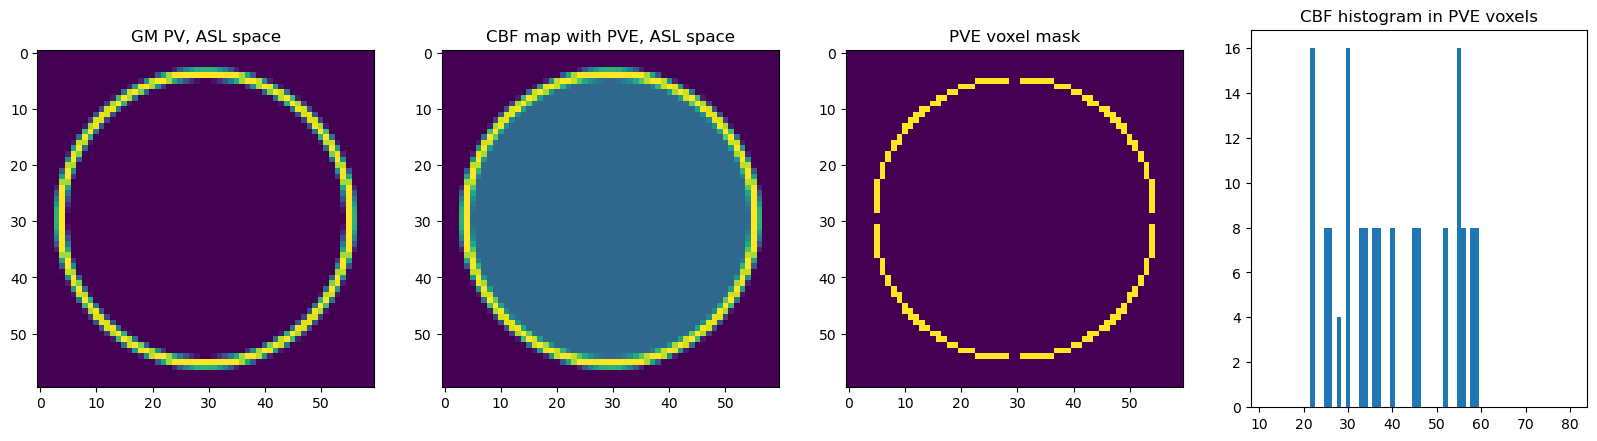

In [5]:
def get_fig(size=(15,5), dpi=100, **kwargs): 
    return plt.figure(figsize=size, dpi=dpi, **kwargs)

bin_edges = np.arange(11.5,81.5,1)
fig = get_fig((20,5))
plt.subplot(1,4,1)
plt.imshow(pvs_asl[:,:,0,0])
plt.title('GM PV, ASL space')
plt.subplot(1,4,2)
plt.imshow(cbf)
plt.title('CBF map with PVE, ASL space')
plt.subplot(1,4,3)
plt.imshow(mask_asl)
plt.title('PVE voxel mask')
plt.subplot(1,4,4)
plt.hist(cbf[mask_asl], bin_edges)
plt.title('CBF histogram in PVE voxels')
plt.show()

### PVEc with linear regression 
PVEc can be performed using linear regression as follows. For each voxel, take the 8 neighbours in the plane (cardinal and diagonal) and assume that the GM / WM CBF values in each are constant across the neighbourhood. The following matrix equation can then be formed: 

$Wx = y$

where $W$ is a 9x2 matrix of PVs (first column GM, second column WM) for the voxel in question and all neighbours; $x$ is a 2x1 vector of [GM,WM] CBF values, and $y$ is a 9x1 vector of CBF values for each voxel (ie, the data with PVE that needs correcting). Because this system is over-determined (more constraints than variables), a least-squares fit can be performed to estimate the optimal CBF values $x$. Though this is a fast and simple method, in practice the assumption of constant CBF over the neighbourhood imposes a high degree of smoothing on the data. In this example, where we know *ahead of time* that our GM / WM CBF values are constant, this doesn't matter. 

The first function forms the adjacency matrix for a 2D grid of voxels, which is then used to find the neighbourhoods of each voxel when actually performing PVEc in the second function. 

In [6]:
def adjacency_matrix(xy_shape):
    # Construct the connectivity matrix of the first row: zeros all the way along, except for the first neighbour
    row = np.zeros(xy_shape[0])
    row[1] = 1 

    # The Toeplitz matrix for this represents the connectivity of the elements within the first row to the 
    # other elements within the row
    sub = spla.toeplitz(row)

    # We want to repeat this pattern for all the other rows: we form a bigger matrix, where the Toeplitz submatrix
    # is repeated along the main diagonal. This represents the linear offset required to index items in the Nth row 
    adj = np.kron(np.eye(xy_shape[1]),sub)

    # For column connectivity, element n connects to element n-N and n+N. These are two big diagonals, offset from 
    # the main by N elements. We also add the diagonal neighbours, ie, n-N+1, n-N-1, n+N+1, n+N-1. These sit as parallel 
    # and adjacent diagonals on either side of the preceeding diagonals  
    # The Kroenecker matrix evaluated the other way round gets us this
    col = np.eye(xy_shape[1])
    col += np.diag(np.ones(col.shape[0]-1),1)
    col += np.diag(np.ones(col.shape[0]-1),-1)
    adj += np.kron(sub,col)

    # Finally, for convenience set the diagonal to 1 (easier to form kernels when doing LR PVEc)
    adj = sparse.dok_matrix(adj, dtype=bool)
    adj[np.diag_indices(adj.shape[0])] = 1
    return adj.tocsr()

def pvec_lr(cbf_pv, pvs, mask, slice_no):
    
    adj = adjacency_matrix(cbf_pv.shape[:2])

    cbf_pv = cbf_pv[...,slice_no]
    pvs = pvs[...,slice_no,:]
    mask = mask[...,slice_no]
    
    cbf_corrected = np.zeros((mask.sum(), 2))
    pvs = pvs.reshape(-1,2)
    cbf_pv = cbf_pv.flatten()
    assert mask.size == pvs.shape[0]

    for idx,vidx in enumerate(np.flatnonzero(mask)):
        neighbours = adj[vidx,:].indices
        y = cbf_pv[neighbours]
        w = pvs[neighbours,:]
        cbf = np.linalg.lstsq(w, y)[0]
        cbf_corrected[idx,:] = cbf

    return cbf_corrected

### PVEc in the ideal case 

Perform PVEc on our CBF data with PVE, to demonstrate that it works: we can get *perfect* recovery of the separate GM, WM signals in this highly artifical example. This is illustrated by the second histogram: there are just two peaks, at 20 and 60, for WM and GM respectively. At a high level, successful PVEc returns the CBF histogram to having two well-defined peaks. 

In [7]:
cbf_pvec = pvec_lr(cbf, pvs_asl, mask_asl, 0)

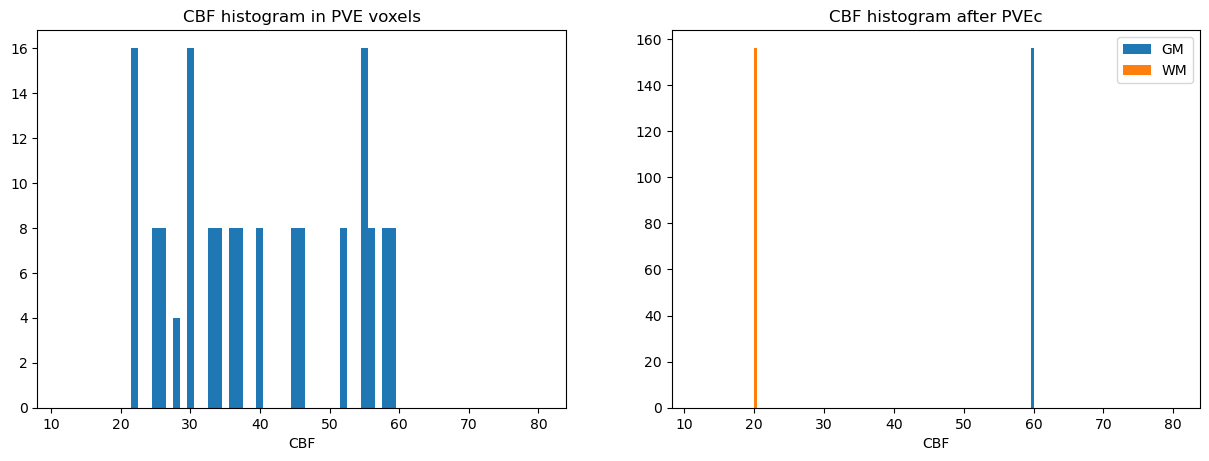

In [8]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl], bin_edges)
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec, bin_edges)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

### PVEc of resampled CBF, with native PVs

We now make the example a bit more realistic. We take the data with PVE and transform it a small amount (ie, a registration) to simulate the process of moving to a common analysis space, or motion correction etc. The transformation is a simple shift in X,Y, and the numbers have indeed been carefully chosen (around 60% of a voxel) to best illustrate the problem (in fact, this interplay between magnitude of transformation and voxel size is also very much part of the problem!) 

![](figs/sim_1.png)

In [9]:
shift = np.array([1.7,4.3])
transform = np.eye(4)
transform[:2,3] = shift
transform = rt.Registration(transform)
transform

Registration (linear) with properties:
src2ref:       [   1.000    0.000    0.000    1.700]
               [   0.000    1.000    0.000    4.300]
               [   0.000    0.000    1.000    0.000]
               [   0.000    0.000    0.000    1.000]

Apply the transformation to the CBF data. Calculate a **new** PV map in alignment with the transformation, aka 'native space' (resampling is not required for this, we use a numerical method). 
Perform PVEc on the *transformed CBF* using the *native PVs*. 

In [10]:
cbf_trans = transform.apply_to_array(cbf, asl_spc, asl_spc)
pv_trans_true = calc_sphere_pvs(sph_cent + shift, R_g, R_w, asl_spc, superfactor)
mask_trans = make_mask(pv_trans_true)
cbf_trans_pvec = pvec_lr(cbf_trans, pv_trans_true, mask_trans, 0)

Plots of the original CBF map, CBF after transformation, and the new GM PV map in native space. 

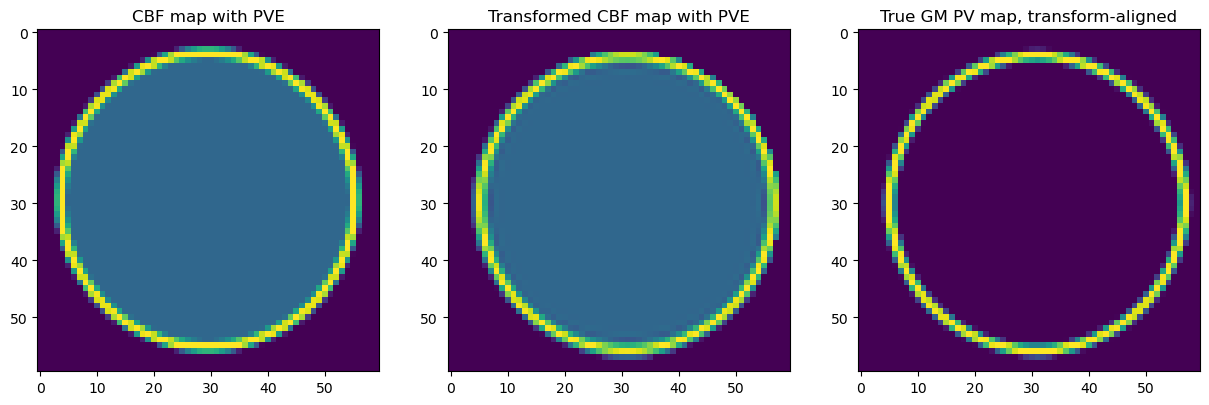

In [11]:
fig = get_fig()
plt.subplot(1,3,1)
plt.imshow(cbf)
plt.title('CBF map with PVE')
plt.subplot(1,3,2)
plt.imshow(cbf_trans)
plt.title('Transformed CBF map with PVE')
plt.subplot(1,3,3)
plt.imshow(pv_trans_true[:,:,0,0])
plt.title('True GM PV map, transform-aligned')
plt.show()

Plot histograms of CBF before and after transformation, and before and after PVEc. As can be seen, we are not able to perfectly recover the original GM / WM CBF values this time around: the distributions have spread around the original values. **This is because interpolation of data that already suffers from PVE introduces an extra confounding effect**, and subsequent PVEc is unable to fully account for this. The confounding effect is seen on the second histogram: after transformation, the distribution of voxels has become even more mixed than before (first histogram), hence why PVEc is not able to perfectly recover the signal. 

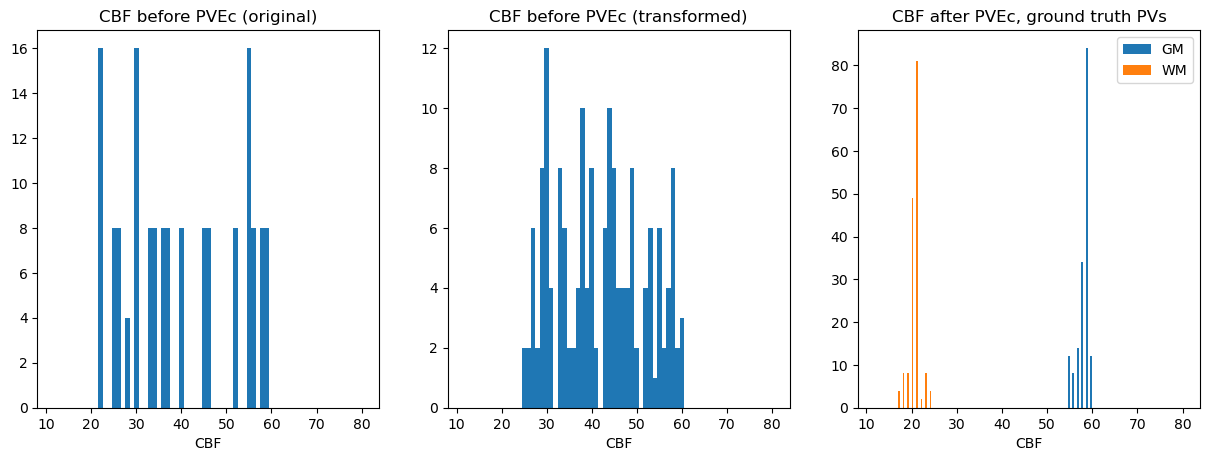

Variance: resampled CBF with PVE, ground truth PV estimates [1.62512789 1.53783957]


In [12]:
fig = get_fig()
plt.subplot(1,3,1)
plt.hist(cbf[mask_asl], bin_edges)
plt.title('CBF before PVEc (original)'); plt.xlabel('CBF')
plt.subplot(1,3,2)
plt.hist(cbf_trans[mask_trans], bin_edges)
plt.title('CBF before PVEc (transformed)'); plt.xlabel('CBF')
plt.subplot(1,3,3)
plt.hist(cbf_trans_pvec, bin_edges)
plt.title('CBF after PVEc, ground truth PVs'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print('Variance: resampled CBF with PVE, ground truth PV estimates', cbf_trans_pvec.var(0))

### PVEc of resampled CBF, with resampled low-res PVs

This time the transformation is applied to both the CBF data with PVE, and the ground truth PV estimates at ASL resolution in the original space (as opposed to calculating them from scratch in the transformed space, which is of course unrealistic in the context of most real life situations). We might hope that because the original PV estimates don't suffer from PVE in themselves (because they exist as separate maps for GM and WM, and have not been mixed together in the same way that the CBF data has), we can still get a half-decent correction from them. 

![](figs/sim_2.png)

In [13]:
pv_trans_resamp = transform.apply_to_array(pvs_asl, asl_spc, asl_spc)
mask_trans_resamp = make_mask(pv_trans_resamp)
cbf_trans_pvec_resamp = pvec_lr(cbf_trans, pv_trans_resamp, mask_trans_resamp, 0)

Plots of the difference between the transformed GM PV estimates and the ground truth in the transformed space; a histogram of those voxel-wise GM differences, and finally the CBF histogram after correction. The differences in transformed PVs wrt ground truth can be as large as 15% of voxel volume. Note that the variance of the corrected CBF is large: though this is largely a numerical artefact of the LR PVEc method, this is nevertheless indicative of the challenges faced when performing PVEc in 'real-life' situations. The cause of the high variance is that the system of equations in each neighbourhood can become ill-conditioned after resampling; namely in a voxel that has some CBF and a very small amount of tissue, the implied CBF after correction must be very large (ie, dividing by a small number). The GM CBF histogram does indeed have some values > 60 units, which is *higher* than the original ground truth. Note also on the histogram there seems to be a bi-modal distribution in WM CBF, with a second peak emerging around 30 units: given that the ground truth CBF for WM is 20, this is clearly GM signal that has been misallocated to the WM class during correction. 

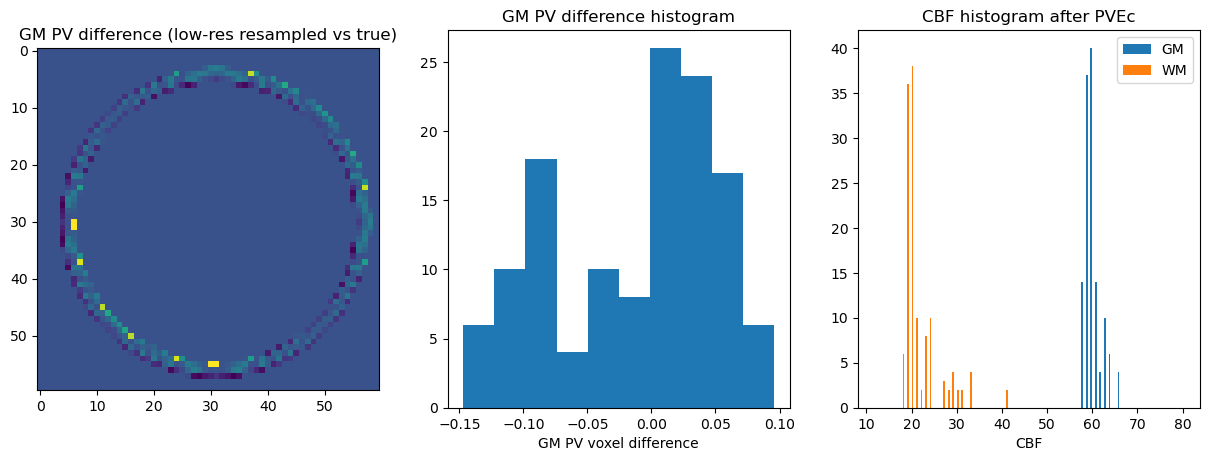

Variance: resampled CBF with PVE, resampled ASL resolution PV estimates [ 3.41963709 19.03519853]


In [14]:
fig = get_fig()
gm_diffs = (pv_trans_true - pv_trans_resamp)[:,:,0,0]
plt.subplot(1,3,1)
plt.imshow(gm_diffs)
plt.title('GM PV difference (low-res resampled vs true)')
plt.subplot(1,3,2)
plt.hist(gm_diffs[mask_trans_resamp[...,0]])
plt.title('GM PV difference histogram'); plt.xlabel('GM PV voxel difference')
plt.subplot(1,3,3)
plt.hist(cbf_trans_pvec_resamp, bin_edges)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print('Variance: resampled CBF with PVE, resampled ASL resolution PV estimates', cbf_trans_pvec_resamp.var(0))

### PVEc of resampled CBF, with resampled high-res PVs

This setup is more representative of a typical analysis pipeline. We have processed the ASL data in some way (motion correction, registration etc) and transform a set of high resolution PV estimates (ie, FAST operating on the T1 image) into alignment with the ASL to perform PVEc. Because high resolution data naturally has a lower level of PVE, it is expected that resampling has less of a detrimental impact, so we should hopefully get a better correction with it. To start with, we calculate PV estimates in the T1 space (0.75mm isotropic resolution) and then apply the same transformation as before. 

![](figs/sim_3.png)

In [15]:
t1_pvs = calc_sphere_pvs(sph_cent, R_g, R_w, t1_spc, 10)
t1_pvs_trans = transform.apply_to_array(t1_pvs, t1_spc, t1_spc)
t1_pvs_trans = rt.application_helpers.sum_array_blocks(t1_pvs_trans, [t1_factor,t1_factor,1,1]) / (t1_factor ** 2)
t1_mask_trans = make_mask(t1_pvs_trans)
cbf_trans_pvec_resamp_high = pvec_lr(cbf_trans, t1_pvs_trans, t1_mask_trans, 0)

Plots of the GM PV difference between resampled high res PVs and ground truth; a histogram of GM PV differences; and the CBF histogram after PVEc. As expected, the voxel-wise differences in GM PV are much smaller than when resampling with low-res PV estimates, leading to a better correction. Notably, the variance in corrected is much smaller - closer to the case when using the ground truth PV estimates - and the distributions themselves are much closer to what we expect. There is no second mode in WM, there are no GM values > 60. 

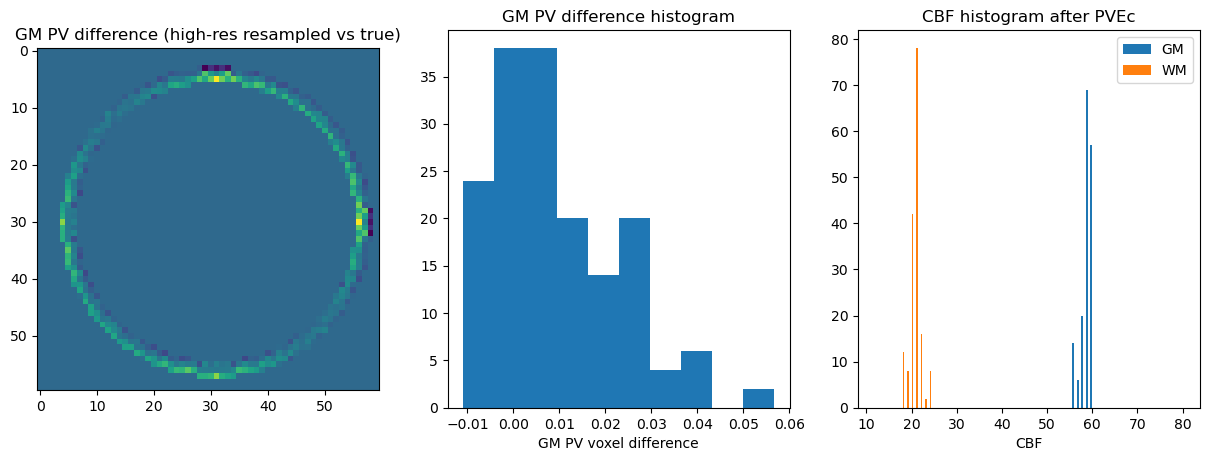

Variance: resampled CBF with PVE, high-res resampled PVs [1.17259004 1.4509827 ]


In [16]:
fig = get_fig()
gm_diffs = (pv_trans_true - t1_pvs_trans)[:,:,0,0]
plt.subplot(1,3,1)
plt.imshow(gm_diffs)
plt.title('GM PV difference (high-res resampled vs true)')
plt.subplot(1,3,2)
plt.hist(gm_diffs[t1_mask_trans[...,0]])
plt.title('GM PV difference histogram'); plt.xlabel('GM PV voxel difference')
plt.subplot(1,3,3)
plt.hist(cbf_trans_pvec_resamp_high, bin_edges)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print('Variance: resampled CBF with PVE, high-res resampled PVs', cbf_trans_pvec_resamp_high.var(0))

### PVEc of native CBF, with resampled high-res PVs

All the examples so far have investigated the behvaiour of PVEc on CBF data that has been resampled in some way. We now generate a new CBF map in the transformed space using the ground truth PV estimates calculated natively in this space. As before, we assume constant CBF of 60 and 20 in GM and WM respectively. We then perform PVEc of this new CBF data using resampled high-res PV estimates *transformed* into alignment with the new CBF. This represents the ideal case where no processing at all is done to the CBF data and only high-resolution data is resampled. 

![](figs/sim_4.png)

In [17]:
cbf2_trans = (GM_CBF * pv_trans_true[...,0]) + (WM_CBF * pv_trans_true[...,1])
cbf2_trans_pvec = pvec_lr(cbf2_trans, t1_pvs_trans, t1_mask_trans, 0)

Plot histograms to compare the case of a) PVEc on resampled CBF data, ground truth native space PV estimates, and b) PVEc on native space CBF, with resampled PV estimates. As can be seen from the histograms, and the variances of the corrected CBFs, it is much better to **transform high-res data into alignment with low-res** than vice-versa. 

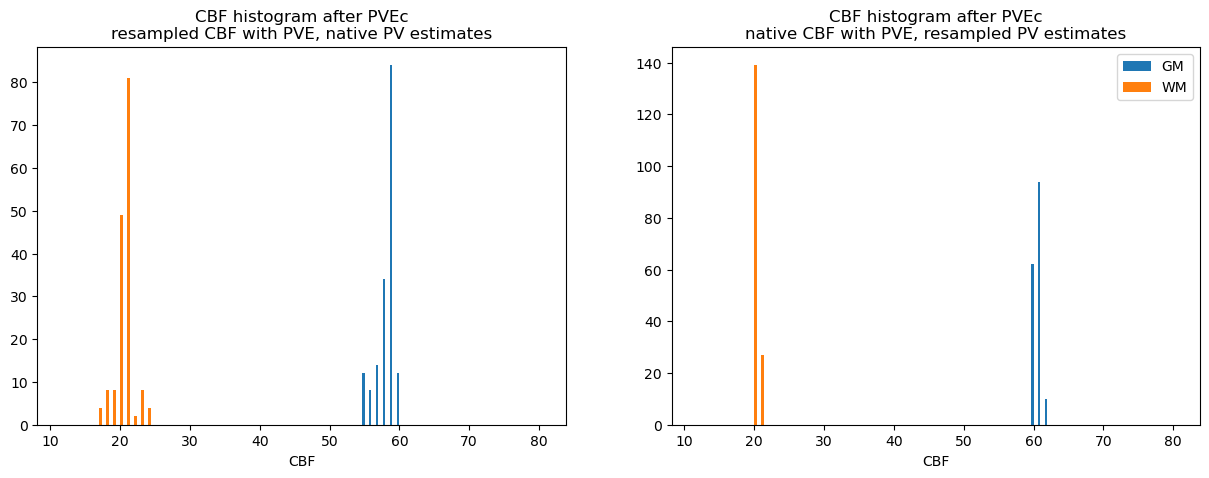

Variance: resampled CBF with PVE, native PV estimates [1.62512789 1.53783957]
Variance: native CBF with PVE, resampled PV estimates [0.13317468 0.07042296]


In [18]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf_trans_pvec, bin_edges); plt.xlabel('CBF')
plt.title('CBF histogram after PVEc\nresampled CBF with PVE, native PV estimates')
plt.subplot(1,2,2)
plt.hist(cbf2_trans_pvec, bin_edges); plt.xlabel('CBF')
plt.title('CBF histogram after PVEc\nnative CBF with PVE, resampled PV estimates')
plt.legend(['GM', 'WM'])
plt.show()
print('Variance: resampled CBF with PVE, native PV estimates', cbf_trans_pvec.var(0))
print('Variance: native CBF with PVE, resampled PV estimates', cbf2_trans_pvec.var(0))

### Resample CBF *after* PVEc (1/2)

What if you really need to transform your CBF data into alignment with something else (repeat acquisitions, other subjects)? It might be better to do the transformation *after* having done PVEc in the native space of the data, as then you will be transforming separate GM / WM CBF maps, and not some mixture of the two. Here, we transform the PVEc CBF map in the original space into the transformed space, and compare the results with the ground truth PVEc map that we have calculated in the transformed space. 

![](figs/sim_5.png)

In [19]:
cbf_wm = WM_CBF * (pvs_asl[...,1] > 0.02)
cbf_gm = GM_CBF * (pvs_asl[...,0] > 0.02)
cbf_wm_trans = transform.apply_to_array(cbf_wm, asl_spc, asl_spc)
cbf_gm_trans = transform.apply_to_array(cbf_gm, asl_spc, asl_spc)

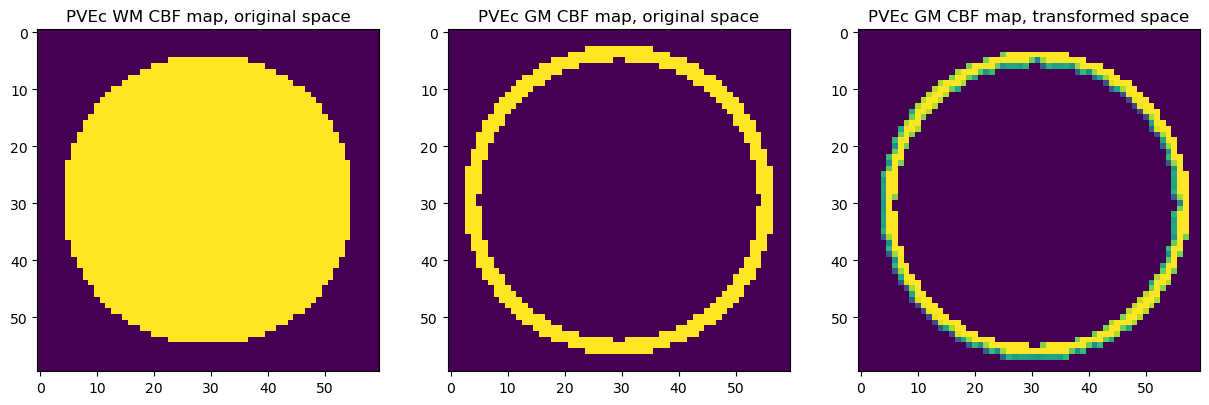

In [20]:
fig = get_fig()
plt.subplot(1,3,1)
plt.imshow(cbf_wm)
plt.title('PVEc WM CBF map, original space')
plt.subplot(1,3,2)
plt.imshow(cbf_gm)
plt.title('PVEc GM CBF map, original space')
plt.subplot(1,3,3)
plt.imshow(cbf_gm_trans)
plt.title('PVEc GM CBF map, transformed space')
plt.show()

Plot the PVEc CBF values after transformation, and compare with the results obtained by performing PVEc on the transformed CBF data with high-res PV estimates. Perhaps surprisingly, this variant performs very badly, likely due to the issues of transforming sharp edges on the PVEc CBF maps (see the transformed PVEc GM CBF map above, a lot of edge signal simply goes 'missing'). As a result, there is signifcant spreading out of signal, particularly in GM. 

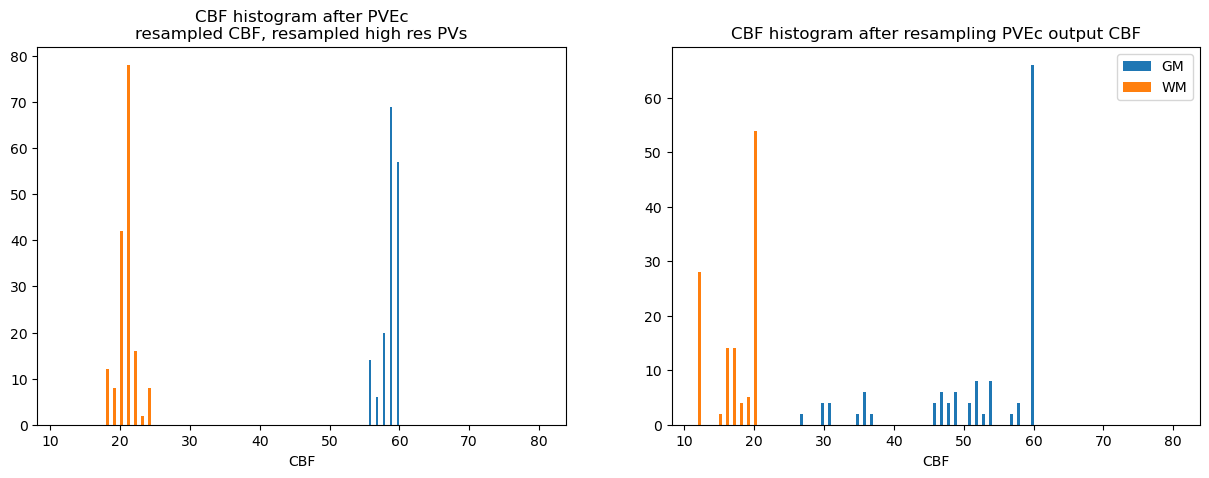

Variance: resample CBF after PVEc 293.6188 96.24404


In [21]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf_trans_pvec_resamp_high, bin_edges)
plt.title('CBF histogram after PVEc\nresampled CBF, resampled high res PVs'); plt.xlabel('CBF')
plt.subplot(1,2,2)
hist = np.array([cbf_gm_trans[mask_trans], cbf_wm_trans[mask_trans]])
plt.hist(hist.T, bin_edges)
plt.title('CBF histogram after resampling PVEc output CBF'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print('Variance: resample CBF after PVEc', cbf_gm_trans.var(), cbf_wm_trans.var())

### Resample CBF *after* PVEc (2/2)

Given the issue with 'missing' signal above, would it be possible to reform the CBF map with PVE after transforming the separate PVEc CBF maps? Ie, could we re-create the PVE after having transformed our corrected data, and then re-perform a round of PVEc in the transformed space? We reform the CBF with PVE in the transformed space by multiplying each transformed CBF map with the corresponding transformed PV map. We then re-run PVEc usuing these same PVs. 

![](figs/sim_6.png)

In [22]:
cbf_trans_reformed = (cbf_gm_trans * t1_pvs_trans[...,0]) + (cbf_wm_trans * t1_pvs_trans[...,1])
cbf_trans_pvec_reformed = pvec_lr(cbf_trans_reformed, t1_pvs_trans, t1_mask_trans, 0)

Plot histograms of this 'reformed' approach with the previous approach of transforming the PVEc output. As can be seen, it does offer a significant improvement, particularly in removing extremely low GM CBF values, but it remains poor compared to the ground truth. It is likely that this variant only appears beneficial compared to the previous one because the second round of PVEc in the transformed space imposes an extra degree of smoothing (which, as discussed previously, is inherent to the LR PVEc approach). 

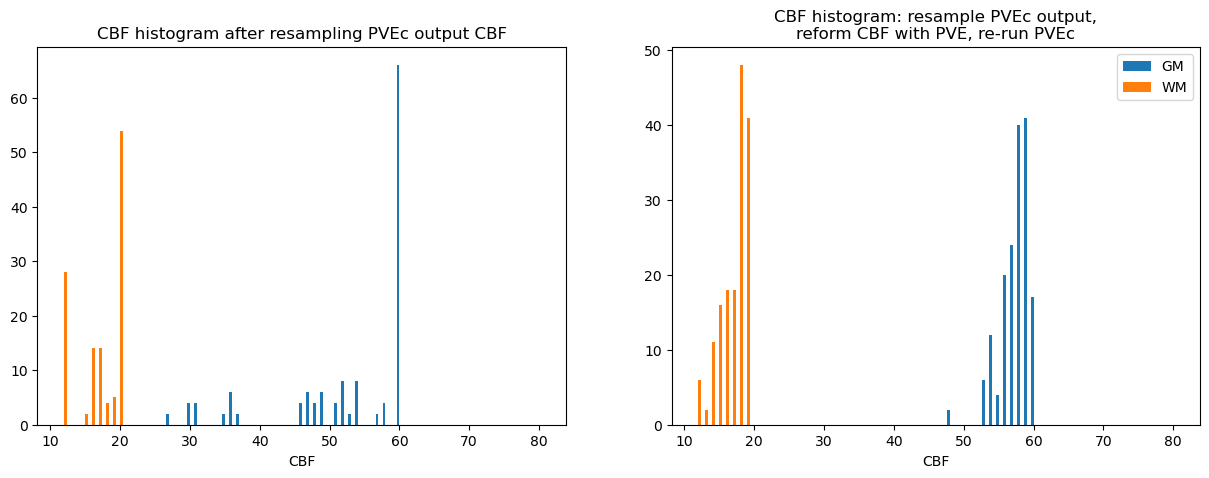

Variance: resample PVEc output, reform CBF with PVE, re-run PVEc [4.0074893  5.90684541]


In [23]:
fig = get_fig()
plt.subplot(1,2,1)
hist = np.array([cbf_gm_trans[mask_trans], cbf_wm_trans[mask_trans]])
plt.hist(hist.T, bin_edges)
plt.title('CBF histogram after resampling PVEc output CBF'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_trans_pvec_reformed, bin_edges)
plt.title('CBF histogram: resample PVEc output,\nreform CBF with PVE, re-run PVEc')
plt.legend(['GM', 'WM']); plt.xlabel('CBF')
plt.show()
print('Variance: resample PVEc output, reform CBF with PVE, re-run PVEc', cbf_trans_pvec_reformed.var(0))

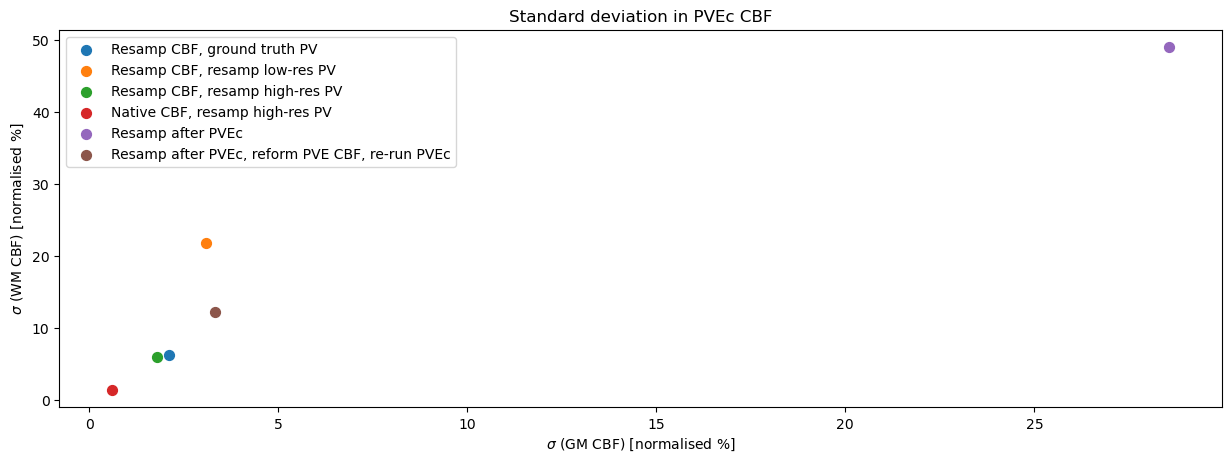

In [24]:
fig = get_fig()
xy = 100 * np.array([
    cbf_trans_pvec.std(0),
    cbf_trans_pvec_resamp.std(0),
    cbf_trans_pvec_resamp_high.std(0),
    cbf2_trans_pvec.std(0), 
    [cbf_gm_trans.std(), cbf_wm_trans.std()],
    cbf_trans_pvec_reformed.std(0)
]) / np.array([GM_CBF, WM_CBF])[None,:]

for idx, title in enumerate([
    'Resamp CBF, ground truth PV', 
    'Resamp CBF, resamp low-res PV', 
    'Resamp CBF, resamp high-res PV', 
    'Native CBF, resamp high-res PV', 
    'Resamp after PVEc', 
    'Resamp after PVEc, reform PVE CBF, re-run PVEc'
]):
    plt.scatter(*xy[idx,:], s=50, label=title)
plt.legend()
plt.xlabel(r"$\sigma$ (GM CBF) [normalised %]")
plt.ylabel(r"$\sigma$ (WM CBF) [normalised %]")
plt.title('Standard deviation in PVEc CBF')
plt.show()

## Real test case: an HCP subject

We use the anatomical data from HCP subject 100318, for which the T1 images were acquired at 0.7mm isotropic. All CBF data is simulated, again using constant CBF in GM/WM, at a resolution of 3mm isotropic. PVs were previously estimated at both resolutions using FreeSurfer, FIRST and Toblerone, *without interpolation*, and the 0.7mm estimates are taken to be of sufficiently high resolution that they are close enough to ground truth. For this demo, the question of ground truth is actually irrelevant, as we generate CBF data with PVE from any arbitrary PV estimates. 

In [25]:
asl_spc = rt.ImageSpace('tob_all_stacked_3.0.nii.gz')
t1_spc = rt.ImageSpace('tob_all_stacked_0.7.nii.gz')
pvs = nibabel.load('tob_all_stacked_3.0.nii.gz').get_fdata()[...,:2]
pvs_high = nibabel.load('tob_all_stacked_0.7.nii.gz').get_fdata()[...,:2]
mid_slice = asl_spc.size[-1] // 2
mid_slice_high = t1_spc.size[-1] // 2
mask = make_mask(pvs)

Plot GM PVs at T1 and ASL resolution, as well as the PVE mask: all voxels that contain both GM and WM. 

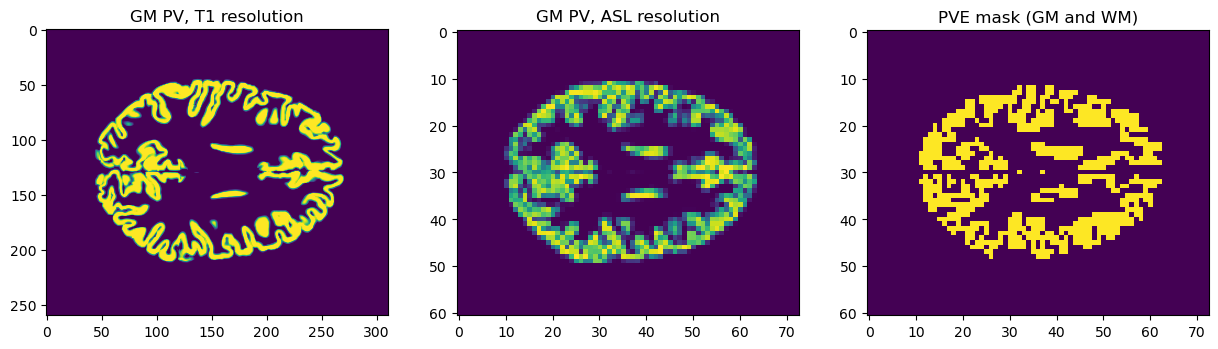

In [26]:
fig = get_fig()
plt.subplot(1,3,1)
plt.imshow(pvs_high[...,mid_slice_high,0])
plt.title('GM PV, T1 resolution')
plt.subplot(1,3,2)
plt.imshow(pvs[...,mid_slice,0])
plt.title('GM PV, ASL resolution')
plt.subplot(1,3,3)
plt.imshow(mask[...,mid_slice])
plt.title('PVE mask (GM and WM)')
plt.show()

Simulate CBF data with PVE, flat CBF for both tissue types. Plot a histogram of voxels within the PVE mask to demonstrate PVE in action. Note that there are two peaks, corresponding to ground truth WM and GM CBF, and a large valley of PVE voxels in between. 

In [27]:
cbf = (GM_CBF * pvs[...,0]) + (WM_CBF * pvs[...,1])

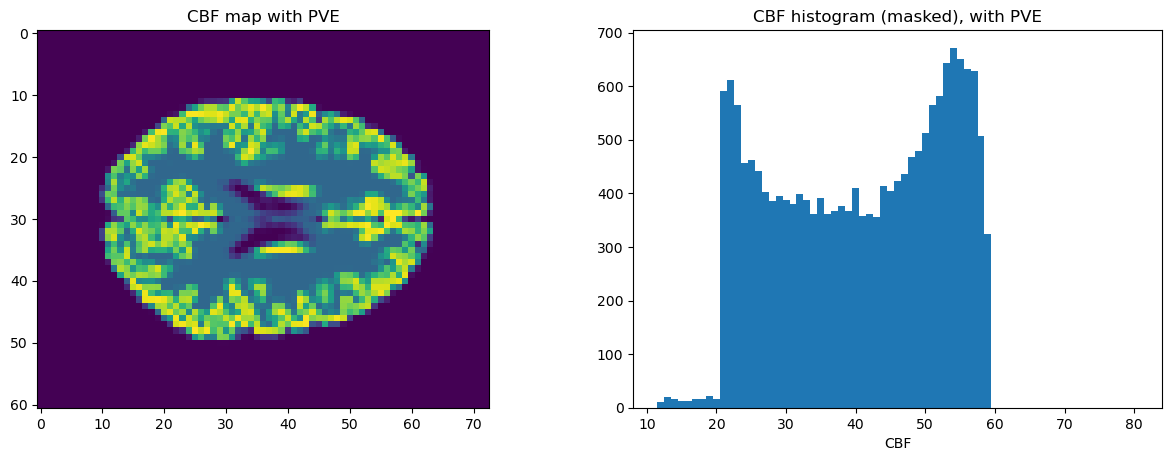

In [28]:
fig = get_fig()
plt.subplot(1,2,1)
plt.imshow(cbf[...,mid_slice])
plt.title('CBF map with PVE')
plt.subplot(1,2,2)
plt.hist(cbf[mask], bin_edges)
plt.title('CBF histogram (masked), with PVE'); plt.xlabel('CBF')
plt.show()

### PVEc with native space CBF and native space PV estimates

Perform PVEc with the CBF and PV data both in their native space (no resampling). We are able to perfectly recover the ground truth GM and WM signals. 

In [29]:
cbf_pvec = pvec_lr(cbf, pvs, mask, mid_slice)

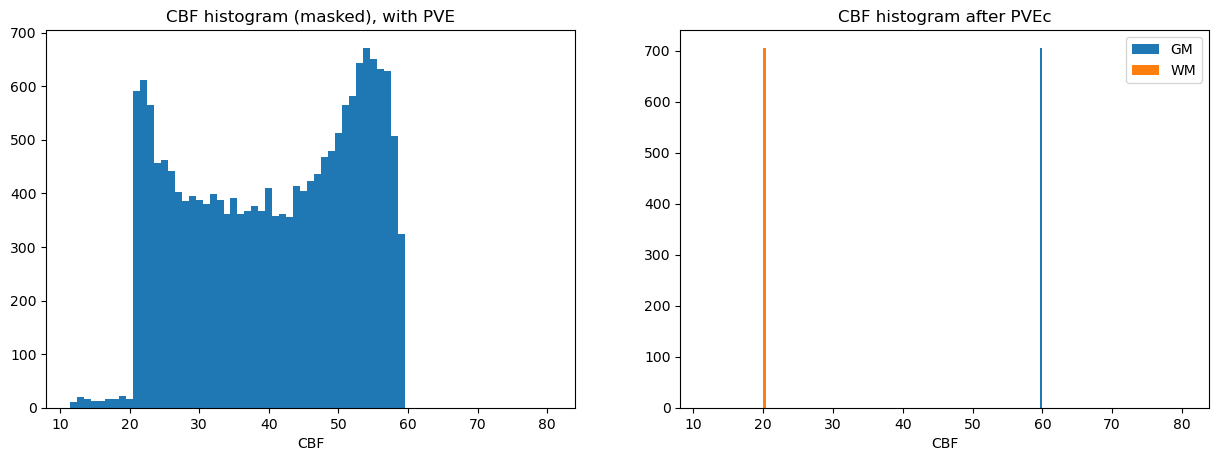

In [30]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask], bin_edges)
plt.title('CBF histogram (masked), with PVE'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec, bin_edges)
plt.title('CBF histogram after PVEc')
plt.legend(['GM', 'WM']); plt.xlabel('CBF')
plt.show()

### PVEc on resampled CBF data

Generate a small transformation in the xy plane: a rotation of 5 degrees, followed by a translation in the range [0,6]mm for both x and y. We then transform the CBF data and the high resolution T1 space PV estimates. This is the 'best' approach as determined from the experiments with the artificial test case. 

In [31]:
rot = Rotation.from_euler('z', 5, degrees=True)
transform = np.eye(4)
transform[:3,:3] = rot.as_matrix() 
transform[:2,3] = 6 * np.random.rand(2)
transform = rt.Registration(transform)
transform

Registration (linear) with properties:
src2ref:       [   0.996   -0.087    0.000    2.876]
               [   0.087    0.996    0.000    4.826]
               [   0.000    0.000    1.000    0.000]
               [   0.000    0.000    0.000    1.000]

In [32]:
cbf_trans = transform.apply_to_array(cbf, asl_spc, asl_spc)
pv_trans = transform.apply_to_array(pvs_high, t1_spc, asl_spc)
mask_trans = make_mask(pv_trans)

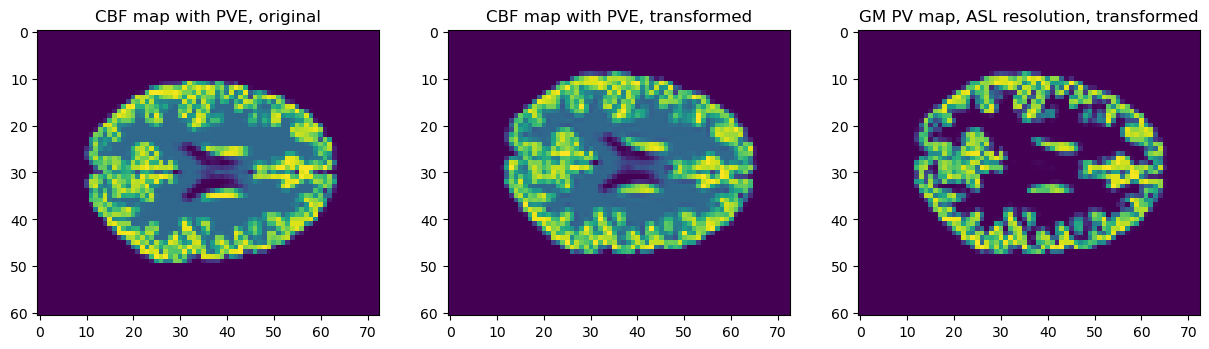

In [33]:
fig = get_fig()
plt.subplot(1,3,1)
plt.imshow(cbf[...,mid_slice])
plt.title('CBF map with PVE, original')
plt.subplot(1,3,2)
plt.imshow(cbf_trans[...,mid_slice])
plt.title('CBF map with PVE, transformed')
plt.subplot(1,3,3)
plt.imshow(pv_trans[...,mid_slice,0])
plt.title('GM PV map, ASL resolution, transformed')
plt.show()

Perform PVEc in the transformed space, using both the transformed CBF data, and the transformed high-res T1 PV estimates. Plot the CBF histogram after correction. As can be seen, the spreading out of signal around each peak is much worse than in the artificial test case, presumably because there are many more voxels, with higher levels of PVE, than previously. Note that the CBF histogram after transformation but before PVEc (second) has lost the two peaks for WM and GM that existed previously; there is now one vague peak in between ground truth GM and WM. 

In [34]:
cbf_pvec_trans = pvec_lr(cbf_trans, pv_trans, mask_trans, mid_slice)

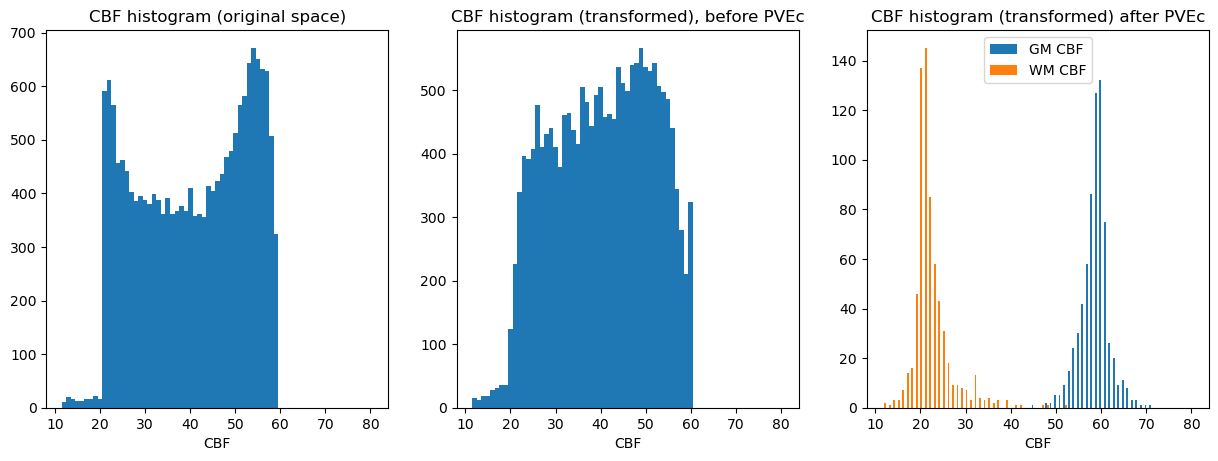

Variance: resample PVEc output, reform CBF with PVE, re-run PVEc [4.0074893  5.90684541]


In [35]:
fig = get_fig()
plt.subplot(1,3,1)
plt.hist(cbf[mask], bin_edges)
plt.title('CBF histogram (original space)'); plt.xlabel('CBF')
plt.subplot(1,3,2)
plt.hist(cbf_trans[mask_trans], bin_edges)
plt.xlabel('CBF'); plt.title('CBF histogram (transformed), before PVEc')
plt.subplot(1,3,3)
plt.hist(cbf_pvec_trans, bin_edges)
plt.xlabel('CBF'); plt.title('CBF histogram (transformed) after PVEc')
plt.legend(['GM CBF', 'WM CBF'])
plt.show()
print('Variance: resample PVEc output, reform CBF with PVE, re-run PVEc', cbf_trans_pvec_reformed.var(0))

### How much of a problem are PVE for repeatability analysis anyway? Repeats with constant CBF. 

Simulate the Maastricht dataset I've been working with: 4 repeat acquisitions. Generate a random transform and apply that to the T1 PVs to get ASL space PV maps, each in their own individual space. Generate CBF maps off each of them, and then apply the reverse transform back into alignment with the original T1 image and calculate CoV. 

Each transformation will be a rotation in the xy plane of [0,10] degrees and an xy translation in the range [0,10] mm. 

To start with, asssume constant CBF in GM and WM. 

In [36]:
cbf_repeats_raw = []
cbf_repeats_trans = []
RPTS = 4
for _ in range(RPTS):
    rot = Rotation.from_euler('z', np.random.randint(0,11), degrees=True)
    transform = np.eye(4)
    transform[:3,:3] = rot.as_matrix() 
    transform[:2,3] = 10 * (np.random.rand(2))
    transform = rt.Registration(transform)
    transform
    
    pv_trans = transform.apply_to_array(pvs_high, t1_spc, asl_spc)
    cbf_raw = (GM_CBF * pv_trans[...,0]) + (WM_CBF * pv_trans[...,1])
    cbf_transformed = transform.inverse().apply_to_array(cbf_raw, asl_spc, asl_spc, order=1)
    cbf_repeats_raw.append(cbf_raw)
    cbf_repeats_trans.append(cbf_transformed)
    
cbf_repeats_trans = np.stack(cbf_repeats_trans, axis=-1)

Display each raw CBF map on the top row, and then the transformed CBF map in the common-aligned analysis space on the bottom row. 

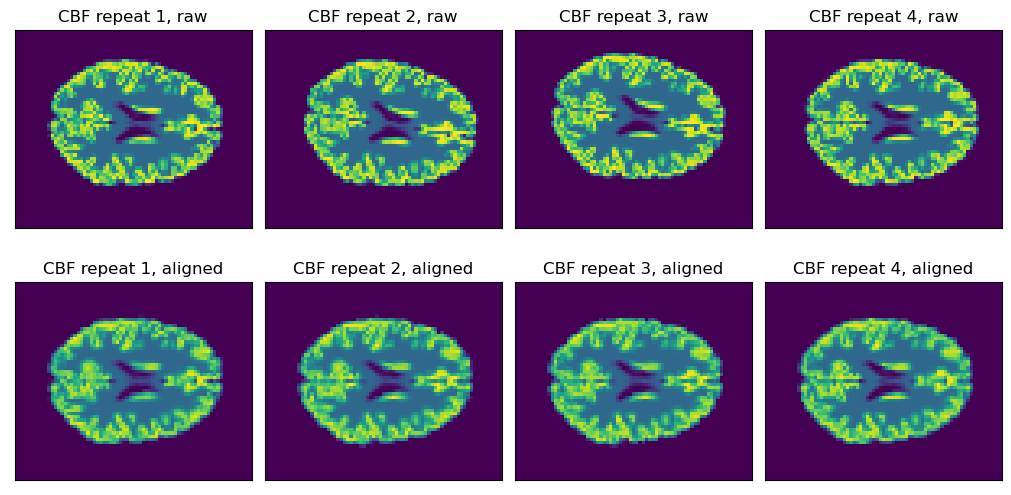

In [37]:
fig = get_fig(size=(10,5), constrained_layout=True)
for r in range(RPTS):
    plt.subplot(2,RPTS,r+1)
    plt.imshow(cbf_repeats_raw[r][:,:,mid_slice])
    plt.xticks([]); plt.yticks([])
    plt.title(f'CBF repeat {r+1}, raw')
    plt.subplot(2,RPTS,r+5)
    plt.imshow(cbf_repeats_trans[:,:,mid_slice,r])
    plt.title(f'CBF repeat {r+1}, aligned')
    plt.xticks([]); plt.yticks([])

Calculate the CoV in PVE voxels across the repeats in the common aligned space. Perform PVEc on each transformed repeat in the common aligned space, using the single map of PV estimates that we previously obtained, and calculate the CoV across repeats in PVEc CBF. 

In [38]:
calc_cov = lambda a: 100 * a.std(-1) / a.mean(-1)
cbf_rpts_cov = calc_cov(cbf_repeats_trans[mask[:,:,mid_slice],mid_slice,:])
cbf_rpts_pvec = [ pvec_lr(cbf_repeats_trans[...,idx], pvs, mask, mid_slice) for idx in range(cbf_repeats_trans.shape[-1]) ] 
cbf_rpts_pvec = np.stack(cbf_rpts_pvec, axis=-1)
cbf_pvec_cov_gm = calc_cov(cbf_rpts_pvec[:,0,:])
cbf_pvec_cov_wm = calc_cov(cbf_rpts_pvec[:,1,:])

Plot voxel-wise CoV in CBF before PVEc, and after PVEc, in each tissue separately. As can be seen, there is a general reduction in GM CoV after performing PVEc, but compared to the case of no PVEc, it would be hard to argue that a major reduction has been obtained. The CoV in WM CBF after PVEc is actually increased compared to no PVEc, probably due to GM signal been allocated to the WM class and therefore dragging up individual voxel CBF values, thereby increasing CoV. In summary, for this highly artificial test case of constant CBF, and using a PVEc method that also assumes constant CBF, PVEc cannot be said to dramatically reduce voxel-wise CoV. 

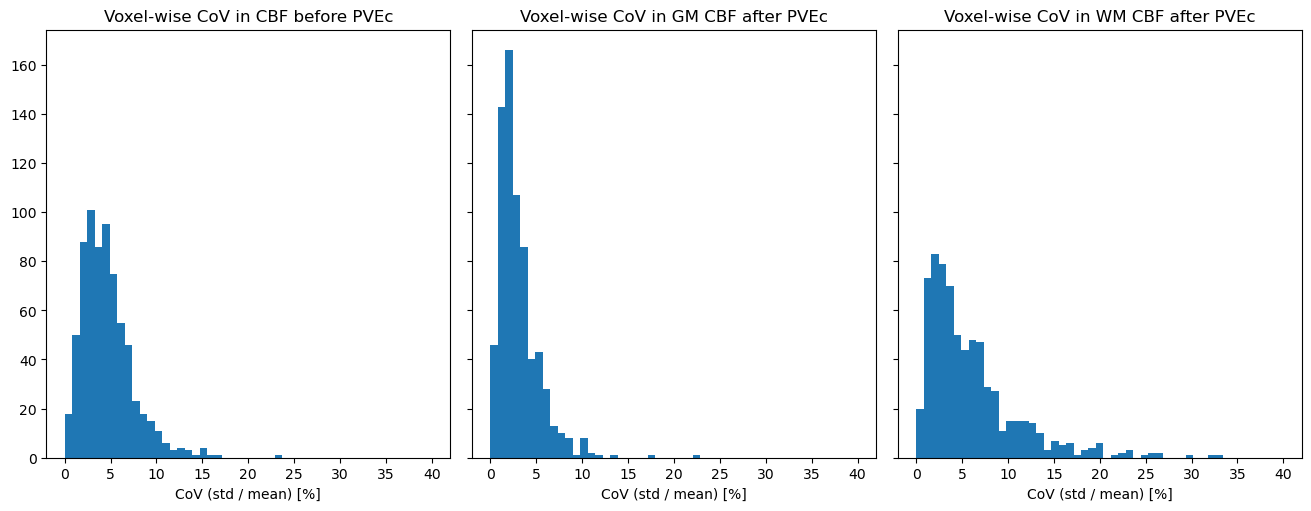

In [39]:
fig, axes = plt.subplots(1,3, sharey=True, constrained_layout=True, dpi=100)
fig.set_size_inches(13,5)
bins = np.linspace(0,40)
axes[0].hist(cbf_rpts_cov, bins)
axes[0].set_title('Voxel-wise CoV in CBF before PVEc'); axes[0].set_xlabel('CoV (std / mean) [%]')
axes[1].hist(cbf_pvec_cov_gm, bins)
axes[1].set_title('Voxel-wise CoV in GM CBF after PVEc'); axes[1].set_xlabel('CoV (std / mean) [%]')
axes[2].hist(cbf_pvec_cov_wm, bins)
axes[2].set_title('Voxel-wise CoV in WM CBF after PVEc'); axes[2].set_xlabel('CoV (std / mean) [%]')
plt.show()

### Repeats with variable CBF

Now consider non-constant CBF, namely normally distributed GM and WM CBF. Repeat the entire process: generate CBF maps, transform them into common aligned space, measure CoV before and after PVEc. 

In [40]:
cbf_repeats_raw = []
cbf_repeats_trans = []
RPTS = 4
for _ in range(RPTS):
    rot = Rotation.from_euler('z', np.random.randint(0,11), degrees=True)
    transform = np.eye(4)
    transform[:3,:3] = rot.as_matrix() 
    transform[:2,3] = 10 * (np.random.rand(2))
    transform = rt.Registration(transform)
    transform
    
    pv_trans = transform.apply_to_array(pvs_high, t1_spc, asl_spc)
    cbf_raw = ((np.random.normal(GM_CBF, 8, asl_spc.size) * pv_trans[...,0]) 
                + (np.random.normal(WM_CBF, 4, asl_spc.size) * pv_trans[...,1]))
    cbf_transformed = transform.inverse().apply_to_array(cbf_raw, asl_spc, asl_spc, order=1)
    cbf_repeats_raw.append(cbf_raw)
    cbf_repeats_trans.append(cbf_transformed)
    
cbf_repeats_trans = np.stack(cbf_repeats_trans, axis=-1)

Plot the raw CBF maps (top row) and the transformed maps in common-aligned space (bottom row). 

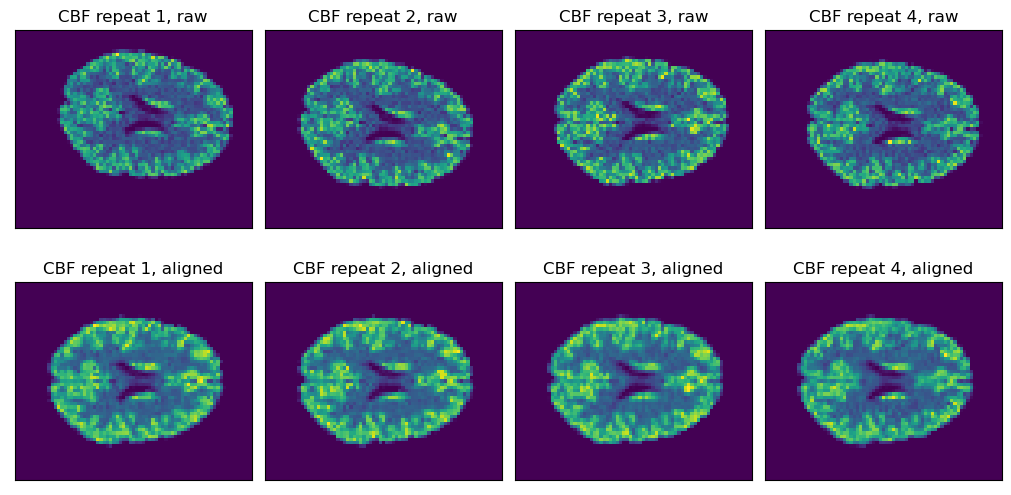

In [41]:
fig = get_fig(size=(10,5), constrained_layout=True)
for r in range(RPTS):
    plt.subplot(2,RPTS,r+1)
    plt.imshow(cbf_repeats_raw[r][:,:,mid_slice])
    plt.xticks([]); plt.yticks([])
    plt.title(f'CBF repeat {r+1}, raw')
    plt.subplot(2,RPTS,r+5)
    plt.imshow(cbf_repeats_trans[:,:,mid_slice,r])
    plt.title(f'CBF repeat {r+1}, aligned')
    plt.xticks([]); plt.yticks([])

Calculate CoV across runs before and after PVEc

In [42]:
cbf_rpts_cov = calc_cov(cbf_repeats_trans[mask[:,:,mid_slice],mid_slice,:])
cbf_rpts_pvec = [ pvec_lr(cbf_repeats_trans[...,idx], pvs, mask, mid_slice) for idx in range(cbf_repeats_trans.shape[-1]) ] 
cbf_rpts_pvec = np.stack(cbf_rpts_pvec, axis=-1)
cbf_pvec_cov_gm = calc_cov(cbf_rpts_pvec[:,0,:])
cbf_pvec_cov_wm = calc_cov(cbf_rpts_pvec[:,1,:])

Histograms of CoV in CBF before and after PVEc. Although CoV is higher in every case compared to the constant CBF simulation, the general trend is the same: a reduction in CoV for PVEc GM CBF compared to no PVEc, and an increase for PVEc WM CBF. 

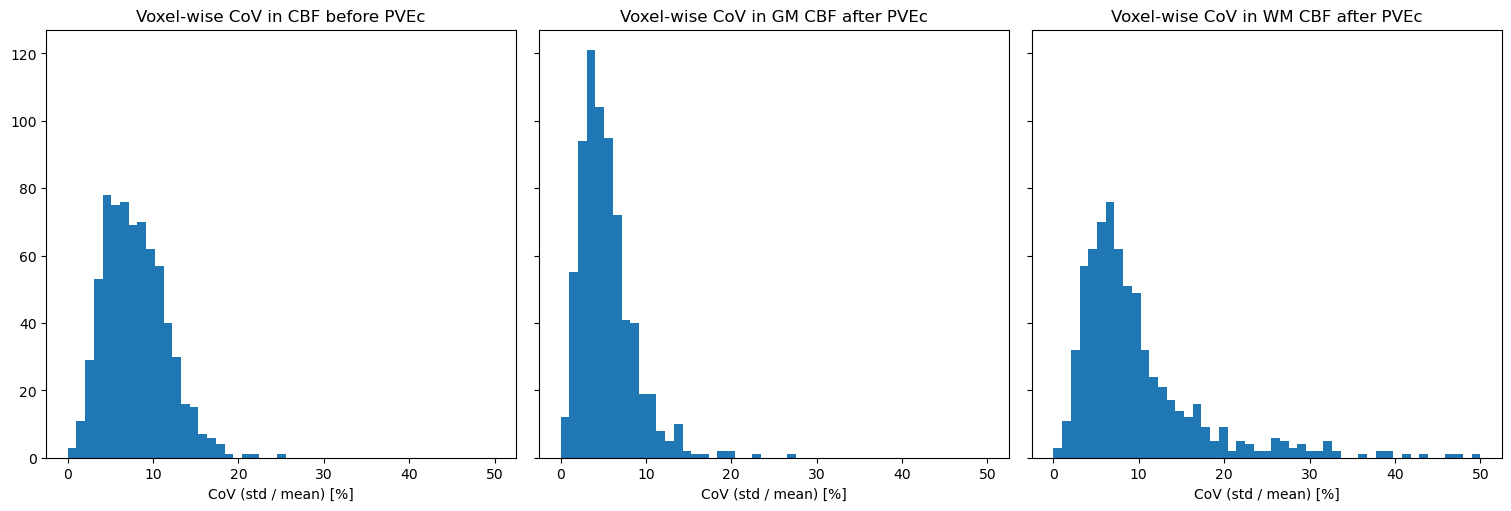

In [43]:
fig, axes = plt.subplots(1,3, sharey=True, constrained_layout=True, dpi=100)
fig.set_size_inches(15,5)
bins = np.linspace(0,50)
axes[0].hist(cbf_rpts_cov, bins)
axes[0].set_title('Voxel-wise CoV in CBF before PVEc'); axes[0].set_xlabel('CoV (std / mean) [%]')
axes[1].hist(cbf_pvec_cov_gm, bins)
axes[1].set_title('Voxel-wise CoV in GM CBF after PVEc'); axes[1].set_xlabel('CoV (std / mean) [%]')
axes[2].hist(cbf_pvec_cov_wm, bins)
axes[2].set_title('Voxel-wise CoV in WM CBF after PVEc'); axes[2].set_xlabel('CoV (std / mean) [%]')
plt.show()

## Discussion 

Simulations demonstrate the PVE do indeed negatively impact the CoV for repeat data that is to be analysed in a common space. However, it is difficult to separate out the effect of resampling and interpolation from this. In order to get data into a common space in which CoV can be calculated, one must resample the separate acquisitions, and simulations on the spherical test case have shown that this in itself introduces insurmountable confounding effects. All in all, resampling and interpolation of data that contains PVE introduces extra mixing that even the most 'perfect' PVEc (ie, ground truth PV estimates, valid simplifying assumptions of constant CBF in regression kernels) is unable to overcome. 

Some general implications: 
1. At all costs, avoid registering / interpolating / resampling data that has been corrputed with PVE. This is because interpolation acts as a confounding effect on top of PVE 
2. If you need to register / interpolate / resample, try and restrict it to data that doesn't have significant PVE (structural data etc)
3. The confounding effect of interpolation is very much dependent on the ratio of voxel resolutions in question. In short, going from fine to coarse resolution is much better than coarse to fine, or even coarse to coarse. 
4. Region-based analysis should be fairly immune to these problems (in the limit, you can think of this approach as being equivalent to resampling a CBF map onto an exceptionally blocky voxel grid, where each output 'voxel' corresponds to a structure that contains dozens of input voxels. 

This analysis was restricted to PVE voxels so perhaps it is excessively pessimisitic. For example, if any pure GM and WM voxels survive the transformation step, they could be used to aid the process of PVEc? This is somewhat moot. Firslty, at 3mm resolution, very few voxels are genuinely pure (see the analysis mask above). Secondly, though the analysis was restricted to PVE voxels, the correction method was not: the regression kernel includes all neighbours, regardless of their PVs. So, in effect, we are already using neighbourhood information to constrain the PVEc process, with the smoothing penalty this imposes. We could increase the size of the regression kernel (use more neighbours), but this would add even more smoothing and therefore may be cheating our way towards improved CoV. 